# Adaptive PDE discretizations on Cartesian grids
## Volume : Non-divergence form PDEs
## Part : Eikonal equation and variants
## Chapter : Eulerian scheme for Riemannian distances

This notebook presents a single pass Eulerian scheme for the Riemannian eikonal equation. It is provided solely for pedagogical purposes.
Indeed, a state of the art C++ implementation, much more optimized and versatile, is provided in the HFM and AGD libraries, for CPU and GPU processors respectively. These optimized implementations are illustrated in the following [notebook on riemannian distance](../Notebooks_FMM/Riemannian.ipynb) and more generally in the [volume of this repository related to general eikonal equations](../Notebooks_FMM/Summary.ipynb). 

The purpose of this notebook is to illustrate the theory and implementation principles underlying the discretization of the (anisotropic) *Riemannian eikonal equation*, and its numerical solution using iterative solvers such as fast sweeping, adaptive Gauss-Siedel iteration, and the fast marching method method. 
The PDE to be solved involves a Riemannian metric $M : \Omega \to S_d^{++}$ on a domain $\Omega\subset R^d$. Denoting by $u : \Omega \to R^d$ the unkown, the problem is written
$$
    \| \nabla u(x)\|_{D(x)} = 1
$$
for all $x \in \Omega$, where $D(x) := M(x)^{-1}$. Dirichlet null boundary conditions are applied on $\partial \Omega$. (Or, in some cases, outflow boundary conditions.)

The solution $u$ should be regarded as the first arrival time of a front originating from the boundary. Minimal paths toward the boundary, also known as minimal geodesics, can be extracted by solving the ODE *backwards in time*:
$$
    \gamma'(t) := V(\gamma(t))
$$
where $V(x) := D(x) \nabla u(x)$. This notebook is devoted to solution of the eikonal PDE, rather than the geodesic backtracking ODE, which can be addressed using standard techniques.

**Important ! Note on CPU computation speed.** Because of intrinsic limitations of the Python programming language, and in particular due to the slow execution of sequential programs, the fast marching eikonal solver implemented in this notebook is *extremely slow*. In particular and in contrast to reasonable expectations, it is slower than the global iteration method, and than the fast sweeping method, which are also implemented for illustration. The fast marching method is here only implemented for pedagogical purposes. Please use the C++ implementation, or some re-implementation of the Python programs presented below in a compiled language, for any application.

The GPU eikonal solver presented in the end of this notebook is reasonably fast, in contrast to the CPU solver, although it could be further accelerated by optimizing the memory layout of data. (Note also that GPU eikonal solvers shine best on three dimensional problems, where more parallelims can be extracted.) Above all, it is much less versatile and general than the GPU eikonal solver provided in the AGD library.

**Note on accuracy.** The eikonal equation solver presented below is extremely basic, and is presented solely for pedagogical purposes. Two optional techniques, implemented in the c++ version allow to increase accuracy: *source factorization*, and the use *second order finite differences* when conditions allow. See the notebook on [high accuracy](../Notebooks_FMM/HighAccuracy.ipynb)

**Reference.** The numerical scheme implemented in this notebook is described in the following publication:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019, IPOL [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. The update operator](#1.-The-update-operator)
  * [2. Iteration policies](#2.-Iteration-policies)
    * [2.1 Global iteration](#2.1-Global-iteration)
    * [2.2 Fast sweeping](#2.2-Fast-sweeping)
    * [2.3 Fast marching](#2.3-Fast-marching)
  * [3. Anisotropic metric](#3.-Anisotropic-metric)
  * [4. GPU acceleration](#4.-GPU-acceleration)
    * [4.1 Update operator](#4.1-Update-operator)
    * [4.2 Cuda kernel](#4.2-Cuda-kernel)
    * [4.3 Global iteration](#4.3-Global-iteration)
    * [4.4 Adaptive Gauss-Siedel iteration](#4.4-Adaptive-Gauss-Siedel-iteration)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('EikonalEulerian','NonDiv')

In [2]:
from agd import Selling
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
from agd.Plotting import imread
norm_infinity = ad.Optimization.norm_infinity

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import heapq
import scipy.linalg

## 1. The update operator

Our discretization of the eikonal equation is based on a decomposition of the inverse tensors to the Riemannian metric, with the following form. For all $x \in \Omega$,
$$
    D(x) = \sum_{1 \leq i \leq I} \rho_i(x) e_i e_i^T
$$
where $\rho_i(x) \geq 0$ is a non-negative weight. The offset $e_i=e_i(x) \in Z^d$ may also depend on the current position $x$.
The numerical scheme reads
$$
    F u (x) := \sum_{1 \leq i \leq I} \rho_i(x) \max \{0,\frac{u(x)-u(x-h e_i)} h, \frac{u(x)-u(x+h e_i)} h\}^2 - 1.
$$
for all discretization points $x$ in the domain interior. Dirichlet or outflow conditions are applied on the boundary. One has to solve $F u \equiv 0$.

**Historical note.**
This numerical scheme was introduced by Rouy in 1992, in the case of an isotropic metric: when $D(x)$ is proportional to the identity matrix. In that special case, the natural tensor decomposition only uses offsets from the canonical basis. It was observed by Sethian in 1996 that it can be solved in a single pass using the fast marching method. 

The extension to arbitrary anisotropic Riemannian metrics, using adequate methods for tensor decomposition, was introduced in :

- Mirebeau, J.-M. (2019). Riemannian Fast-Marching on Cartesian Grids, Using Voronoi's First Reduction of Quadratic Forms. SIAM Journal on Numerical Analysis, 57(6), 2608–2655.


<!---ExoFR
Implémenter le schéma numérique $F$ il servira à vérifier que l'équation eikonale discrétisée à été correctement résolue. On étend $u$ par $+\infty$ en dehors du domaine (conditions de flot sortant).
--->

<!---ExoCode
def Scheme(u,coefs,offsets,h):
    residue =  # TODO. Hint : fd.DiffUpwind(u,offsets,gridScale=h,padding=np.inf)
    boundary = np.logical_or.reduce(np.isnan(coefs),axis=0)
    return np.where(boundary,0.,residue)
--->

In [4]:
def Scheme(u,coefs,offsets,h):
    v = np.maximum(0,np.maximum(-fd.DiffUpwind(u, offsets,gridScale=h,padding=np.inf),
                                -fd.DiffUpwind(u,-offsets,gridScale=h,padding=np.inf)))
    residue = (coefs*np.maximum(0,v)**2).sum(axis=0) - 1.
    boundary = np.logical_or.reduce(np.isnan(coefs),axis=0)
    return np.where(boundary,0.,residue)

In contrast with the other notebooks of this series, we will not use a Newton method to solve this numerical scheme. Instead, we rely on Gauss-Siedel or Jacobi iterations. In other words we solve, pointwise, the equation $Fu(x) = 0$ with respect to the unknown $u(x)$, assuming that $u(y)$ is fixed for all $y \neq x$. This defines an updated value of $u(x)$, and the process is repeated until convergence, following an order in the domain that is discussed below.

**Gauss-Siedel update of $u(x)$.** Consider a fixed point $x \in \Omega$, and denote, for all $1 \leq i \leq I$,
$$
    v_i := \min \{u(x-h e_i), u(x+h e_i)\}.
$$
The value of the Gauss-Siedel/Jacobi update is the unique solution $\lambda = u(x)$ to the equation
$$
    \sum_{1 \leq i \leq I} \rho_i (\lambda-v_i)_+^2 - h^2 = 0,
$$
where $a_+ := \max \{0,a\}$.

**Exact solution, obtained by sorting, and solving quadratic polynomials.**
By a monotony argument, there exists a unique solution $\lambda \in R$ to the above equation. 
Assume that $v_1 \leq \cdots \leq v_I$, up to sorting these quantities, and denote $v_{I+1}=\infty$ by convention.
Let $1 \leq J \leq I$ denote the unique integer such that 
$$
    \lambda \in [v_J,v_{J+1}].
$$
Then $\lambda$ is the solution to a quadratic equation
$$
    \alpha \lambda^2 - 2 \beta \lambda + \gamma = 0
$$
where 
$$
    \alpha := \sum_{1 \leq i \leq J} \rho_i, \quad \beta := \sum_{1 \leq i \leq J} \rho_i v_i, \quad \gamma := -h^2+\sum_{i \leq J} \rho_i v_i^2.
$$

<!---ExoFR
Compléter la fonction ci-dessous qui calcule la mise à jour de Gauss-Siedel/Jacobi.
--->

<!---ExoCode
def Update(u,coefs,offsets,h,where=(Ellipsis,)):
    """Local Gauss-Siedel update for the fast marching algorithm"""
    #Get the values at the neighbors, and sort them
    v = np.minimum(fd.TakeAtOffset(u, offsets,padding=np.inf,where=where),
                   fd.TakeAtOffset(u,-offsets,padding=np.inf,where=where))
    
    u,coefs=u[where],coefs[(slice(None),)+where] # Akin to coefs[:,where]
    
    v[coefs==0.] = np.inf; 
    ai=v.argsort(axis=0)
    v,coefs = (np.take_along_axis(a,ai,axis=0) for a in (v,coefs))
    
    # Initialize the variables
    result= np.zeros_like(u)
    result[v[0]==np.inf]=np.inf # Far points
    boundary = np.logical_or.reduce(np.isnan(coefs),axis=0)
    result[boundary]=u[boundary] # Apply bc
    considered = np.logical_and(v[0]<np.inf, np.logical_not(boundary))    
    v[:,np.logical_not(considered)] = np.nan; coefs[:,np.logical_not(considered)] = np.nan
    
    alpha = coefs[0]
    beta  = np.zeros_like(u)
    gamma = np.zeros_like(u) - h**2
    solution = h/np.sqrt(alpha)
    result[considered] = v[0,considered]+solution[considered] # Update from closest neighbor
        
    # Solve the quadratic equations
    for rhoi, vi in zip(coefs[1:],v[1:]-v[0]):
        considered = np.logical_and(considered,np.inf>vi)
        vi = np.asarray(vi)
        vi[vi==np.inf]=np.nan
        
        alpha+= # TODO
        beta += # TODO
        gamma+= # TODO
        
        delta = # TODO 
        sdelta = np.sqrt(np.maximum(0.,delta))
        considered = np.logical_and(considered,delta>0)

        solution = # TODO
        considered = np.logical_and(considered,solution>vi)
        result[considered]= v[0,considered]+solution[considered]
        
    return result
--->

In [5]:
def gtr_silentNaN(a,b):
    """Compare two values without emitting a warning for NaNs"""
    from numpy import warnings
    with np.warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return a>b
    
def Update(u,coefs,offsets,h,where=(Ellipsis,)):
    """Local Gauss-Siedel update for the fast marching algorithm"""
    #Get the values at the neighbors, and sort them
    v = np.minimum(fd.TakeAtOffset(u, offsets,padding=np.inf,where=where),
                   fd.TakeAtOffset(u,-offsets,padding=np.inf,where=where))
    
    u,coefs=u[where],coefs[(slice(None),)+where] # Akin to coefs[:,where]
    
    v[coefs==0.] = np.inf; 
    ai=v.argsort(axis=0)
    v,coefs = (np.take_along_axis(a,ai,axis=0) for a in (v,coefs))
    
    # Initialize the variables
    result= np.zeros_like(u)
    result[v[0]==np.inf]=np.inf # Far points
    boundary = np.logical_or.reduce(np.isnan(coefs),axis=0)
    result[boundary]=u[boundary] # Apply bc
    considered = np.logical_and(v[0]<np.inf, np.logical_not(boundary))    
    v[:,np.logical_not(considered)] = np.nan; coefs[:,np.logical_not(considered)] = np.nan
    
    α = coefs[0]
    β  = np.zeros_like(u)
    γ = np.zeros_like(u) - h**2
    solution = h/np.sqrt(α)
    result[considered] = v[0,considered]+solution[considered] # Update from closest neighbor
        
    # Solve the quadratic equations
    for ρi, vi in zip(coefs[1:],v[1:]-v[0]):
        considered = np.logical_and(considered,gtr_silentNaN(np.inf,vi))
        vi = np.asarray(vi)
        vi[vi==np.inf]=np.nan
        
        α+=ρi
        β+=ρi*vi
        γ+=ρi*vi**2
        
        δ = β**2 - γ*α
        sδ = np.sqrt(np.maximum(0.,δ))
        considered = np.logical_and(considered,gtr_silentNaN(δ,0)) #delta>0.

        solution = (β+sδ)/α
        considered = np.logical_and(considered,gtr_silentNaN(solution,vi)) #solution>vi
        result[considered]= v[0,considered]+solution[considered]
        
    return result

We next define the some problem parameters, in order to test the scheme.
As a start, we use an isotropic metric on the square, with a single seed point in the center.

In [6]:
#Define the square [-1,1]^2, sampled on a cartesian grid
aX0 = np.linspace(-1,1,51); aX1 = aX0
gridScale=aX0[1]-aX0[0]
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')

# Define the domain, and the problem parameters
metric = fd.as_field(np.eye(2),X0.shape)
bc=np.full(X0.shape,np.nan)
bc[X0.shape[0]//2,X0.shape[1]//2] = 0

# Decompose the tensors dual to the Riemannian metric
coefs, offsets = Selling.Decomposition(lp.inverse(metric))
coefs[:,np.logical_not(np.isnan(bc))] = np.nan

In [7]:
#u0=np.where(np.isnan(bc),np.inf,bc)
#Update(u0,coefs,offsets,gridScale)

## 2. Iteration policies

We present three classical iteration policies, applied to the Gauss-Siedel update implemented in the previous section. The justification of their convergence is based on mathematical properties, referred to as *Monotony* and *Causality*.

**Monotony.** Denote by $\Lambda$ the Gauss-Siedel update operator implemented above. This operator obeys a property known as *monotony*: for any discrete maps $u,v$
$$
    u\leq v \Rightarrow \Lambda u \leq \Lambda v,
$$
where $u\leq v$ means that $u(x) \leq v(x)$ for all points $x\in X$ of the discretization domain $X$.
Monotony is inherited from another property of the numerical scheme $F$, w.r.t. which the the Gauss-Siedel update is defined, known as *degenerate ellipticity*: $Fu(x)$ is a non-decreasing function of the finite differences $u(x)-u(y)$, $y \neq x$.

**Iterative methods**
Thanks to monotony, and under mild additional technical assumptions, the repeated iteration of the updates over the domain defines a sequence converging to the numerical scheme solution. The updates may be applied simultaneously to all points of the domain, or one by one, or in groups... as in the following variants.
* *Global iteration, also known as Jacobi iteration.* Set $u(x) \gets \Lambda u(x)$ simultaneously for all $x\in X$.
* *Fast sweeping.* Set $u(x) \gets \Lambda u(x)$ simultaneously for all $x$ in a slice of the domain. Iterate slice by slice: left to right, right to left, top to bottom, bottom to top, and then repeat.
* *Adaptive Gauss-Siedel Iteration.* Define an arbitrary ordering sequence, possibly using to a queue with adequate insertion rules. (See the GPU eikonal solver in the end of this notebook.)

Iterations are stopped when a stopping criterion is met. If the initialization $u_0$ equals $+\infty$ in the domain interior, or is a sufficiently large value, then one easily shows using monotonicity that the successive iterates obey $u_{n+1} \leq u_n$. A typical stopping criterion is then 
$$
    u_{n+1} \geq u_n+ \epsilon,
$$
where $\epsilon>0$ is a given tolerance.

**Causality.** The Gauss-Siedel update operator corresponding to our numerical scheme benefits from an additional property, known as causality: informally, for any discrete map $u$ 
$$
    \Lambda u(x) \text{ may depend on } u(y) \text{ only if } u(y) < \Lambda u(x).
$$
Causality is inherited from another property of the numerical scheme $F$, also referred to as causality: $Fu(x)$ only depends on the non-negative part of the finite differences $u(x)-u(y)$, $y\neq x$.
Note that, in addition, $u(x)$ may depend on $u(y)$ only if $y$ appears in the stencil of $x$, in other words $y = x\pm h e_i$ for some $1 \leq i \leq I$.

**Single pass solution.**
Thanks to monotony and causality, and under mild additional technical assumptions, the system of equations discretizing the PDE can be solved in a *single pass* over the domain, by visiting each point a finite number of times that is prescribed in advance. For that purpose, a variant of Dijkstra's shortest path algorithm is used, known as the fast marching method.

In contrast with the iterative methods, the fast marching does not require a stopping criterion since it naturally stops after a finite number of steps.

### 2.1 Global iteration

This procedure, also known as Jacobi iteration, simultaneously updates the unknown function $u$ over all the domain. 

In [8]:
def GlobalIteration(update,u0,args,eps=1e-6,niter_max=200):
    u=u0.copy()
    for niter in range(niter_max):
        u,u_old = update(u,*args),u
        if np.all(u+eps>=u_old):
            return u,niter
    print("Iterative method did not reach stopping criterion within iteration budget")
    return u,niter_max

In [9]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution,nupdate = GlobalIteration(Update,u0,(coefs,offsets,gridScale))

CPU times: user 28.1 ms, sys: 232 µs, total: 28.3 ms
Wall time: 28.3 ms


The number of updates per point `niter` is quite large with this approach, since the front progresses only by one pixel at a time. 
Therefore `niter` is not far from the domain diameter, measured in pixels.
More precisely, `niter` is the length of the longest minimal path in the domain, measured in pixels. 

In [10]:
print("Average number of updates per point :", nupdate)

Average number of updates per point : 50


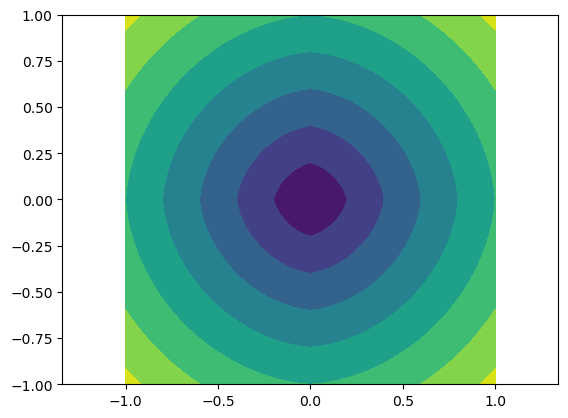

In [11]:
plt.axis('equal')
plt.contourf(X0,X1,solution);

Let us check that the system of equations is indeed solved.

In [12]:
residue = Scheme(solution,coefs,offsets,gridScale)
assert norm_infinity(residue)<1e-13

### 2.2 Fast sweeping

In this approach, solution is updated slice after slice, left to right, right to left, top to bottom, bottom to top, etc. On large domains, the number of updates per pixel is usually smaller than with the global iteration approach.

On a domaine of shape $N_x \times N_y$, the Fast sweeping method repeats the following steps until convergence is achieved
* For $x$ from $1$ to $N_x$
    - For $y$ from $1$ to $N_y$ in parallel: update $u(x,y)$
* For $x$ from $N_x$ to $1$
    - For $y$ from $1$ to $N_y$ in parallel: update $u(x,y)$
* For $y$ from $1$ to $N_y$
    - For $x$ from $1$ to $N_x$ in parallel: update $u(x,y)$
* For y from $N_y$ to $1$
    - For $x$ from $1$ to $N_x$ in parallel: update $u(x,y)$
    
Some variants of the fast sweeping method use diagonal sweeps, rather than axis aligned ones as above.

<!---ExoFR
Compléter la fonction suivante, qui produit les slices utilisées par la méthode du fast sweeping.
--->

<!---ExoCode
def SweepSlices(shape):
    """Produit les slices utilisées par la méthode du fast sweeping."""
    Nx,Ny = shape
    s = slice(None) # Means everyone
    for x in range(Nx): yield (x,s)
    for x # TODO
    # TODO
--->

<!---
def SweepSlices(shape):
    Nx,Ny = shape
    s = slice(None) # Means everyone
    for x in range(Nx): yield (x,s)
    for x in reversed(range(Nx)): yield (x,s)
    for y in range(Ny): yield (s,y)
    for y in reversed(range(Nx)): yield (s,y)
--->

In [13]:
def SweepSlices(shape):
    """Enumerates the slices used in the fast sweeping method."""
    dim = len(shape)
    s=(slice(None),)
    for d,n in enumerate(shape):
        for x in itertools.chain(range(n),reversed(range(n))):
            # [:,...(d times),:, x, :,...(dim-d-1 times),:]
            yield s*d +(x,)+s*(dim-d-1) 

In [14]:
def SweepIteration(update,u0,args,eps=1e-6,niter_max=100):
    u=u0.copy()
    for niter in range(niter_max):
        u_old=u.copy()
        for sl in SweepSlices(u0.shape):
            u[sl]=update(u,*args,where=sl)
        if np.all(u+eps>=u_old):
            return u,niter*2*u0.ndim
    print("Iterative method did not reach stopping criterion within iteration budget")
    return u,niter_max *2*u0.ndim

**Note on execution time.** 
For some reason that needs to be clarified, the update of a slice of the domain costs almost as much as the update of the full domain with this Python implementation. (This is possibly an issue with memory management.) As a result, execution time is here much larger than with the global iteration approach. 

This is not the expected behavior : for reasonably optimized implementations of the fast sweeping method, usually written in compiled languages to reduced overhead, the fast-sweeping method is less numerically intensive than global iteration. 

In [15]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution,nupdate = SweepIteration(Update,u0,(coefs,offsets,gridScale))

CPU times: user 305 ms, sys: 954 µs, total: 306 ms
Wall time: 306 ms


In principle, fast sweeping allows to substantially reduce the number of updates per point in comparison with global iteration. This effect is pronounced over large domains, but is not much observed in very small domains as here.

In [16]:
print("Average number of updates per point :", nupdate)

Average number of updates per point : 48


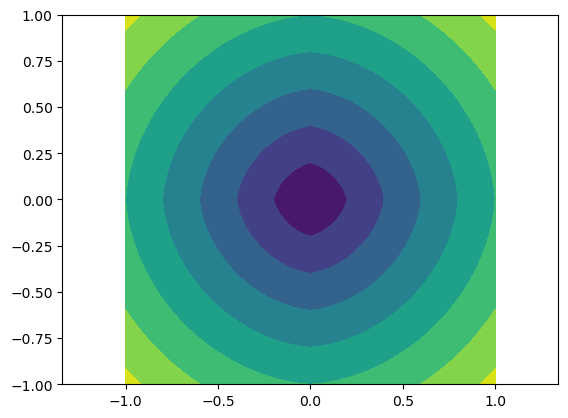

In [17]:
plt.axis('equal')
plt.contourf(X0,X1,solution);

In [18]:
residue = Scheme(solution,coefs,offsets,gridScale)
assert norm_infinity(residue)<1e-13

### 2.3 Fast marching

The fast marching method updates the solution point after point in a very specific order. It works in a Dijkstra-like fashion, taking advantage of the causality of the numerical scheme.

A preliminary step, achieved in the `ReverseNeighbors` routine, is to identify all the *reverse neighbors* of a given point $y \in X$. In other words all $x \in X$ such that $y = x \pm h e_i(x)$ for some $1 \leq i \leq I$.

In [19]:
def ReverseNeighbors(shape,offsets):
    """Reverses a directed graph, defined by offsets on a cartesian grid. 
    The reverse neighbors for index i are orig[changes[i]:changes[i+1]], 
    where (orig,changes) is the output."""
    # Get original and neighbor offset
    neigh,inside = fd.OffsetToIndex(shape,offsets)
    size = np.prod(shape)
    orig = np.broadcast_to(np.arange(size),(neigh.size//size,size)).flatten()
    orig,neigh=orig[inside.flatten()],neigh[inside].flatten()

    # Sort according to neighbor offset
    ind = np.lexsort((orig,neigh))
    orig,neigh=orig[ind],neigh[ind]
    
    # Count
    changes = np.arange(1,neigh.size)[neigh[1:]!=neigh[:-1]]
    changes = np.append(np.insert(changes,0,0),neigh.size)
    return orig,changes

def FastMarching(update,u0,args):
    
    # Compute the reverse neighbors
    _,offsets,_ = args
    rev,chg = ReverseNeighbors(u0.shape,np.stack((offsets,-offsets),axis=1))

    # Find the seeds
    seeds = u0<np.inf
    heap=[(value,index) for value,index in zip(u0[seeds],np.arange(u0.size)[seeds.flatten()]) ]
    heapq.heapify(heap)
    
    # Run the Dijkstra-like method
    accepted = np.full(u0.shape,False).flatten()
    u = u0.copy().flatten()
    niter=0
    while heap:
        # Find the non-accepted point with smallest value
        value,index = heapq.heappop(heap)
        if value > u[index]: continue
        accepted[index]=True
        # Update the neighbors
        for index2 in rev[chg[index]:chg[index+1]]:
            if accepted[index2]: continue
            value2 = update(u.reshape(u0.shape),*args,where=np.unravel_index(index2,u0.shape))
            niter+=1
            if value2 < u[index2]:
                u[index2]=value2
                heapq.heappush(heap,(value2,index2))
    return u.reshape(u0.shape),niter/u0.size

**Note on execution time.** Again, the computation time observed here is not representative of what is obtained in a compiled language, compatible with sequential execution on a mutable state.

For reasonably optimized implementations, the FMM is expected to be faster than fast-sweeping.

In [20]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution,nupdate = FastMarching(Update,u0,(coefs,offsets,gridScale))

CPU times: user 858 ms, sys: 2.81 ms, total: 861 ms
Wall time: 862 ms


The number of updates per point is greatly reduced w.r.t. the fast sweeping method (and global iteration as well). In some implementations, this can be counterbalanced by the cost of maintaining a priority queue.

In [21]:
print("Average number of updates per point :", nupdate)

Average number of updates per point : 2.9219530949634756


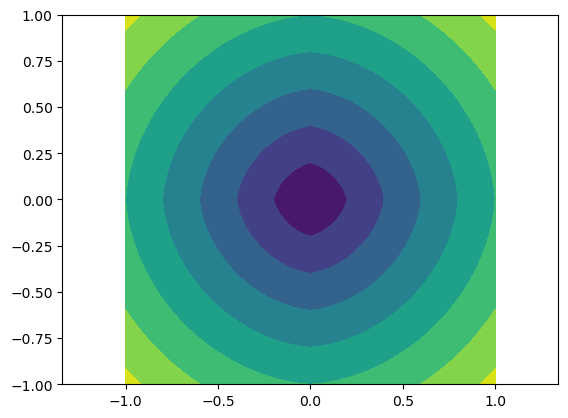

In [22]:
plt.axis('equal')
plt.contourf(X0,X1,solution);

Despite the smaller number of updates per point, the system is exactly solved.

In [23]:
residue = Scheme(solution,coefs,offsets,gridScale)
assert norm_infinity(residue)<1e-13

## 3. Anisotropic metric

The numerical schemes above presented apply without modification to non-constant, anisotropic Riemannian metrics.

In [24]:
#Define the square [-1,1]^2, sampled on a cartesian grid
aX0 = np.linspace(-1,1,51); aX1 = aX0
gridScale=aX0[1]-aX0[0]
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')

# Generate the metric
eig1 = np.stack((np.full(X0.shape,1.),(np.pi/2)*np.cos(2*np.pi*X0)))
eig1 /= scipy.linalg.norm(eig1,axis=0) 
eig2 = np.stack( (eig1[1],-eig1[0]) ) # Rotate eig1 by pi/2
lambda1, lambda2 = 0.8, 0.2
metric = lambda1**-2*lp.outer_self(eig1) + lambda2**-2*lp.outer_self(eig2)

# Decompose the tensors dual to the Riemannian metric
coefs, offsets = Selling.Decomposition(lp.inverse(metric))
coefs[:,np.logical_not(np.isnan(bc))] = np.nan

In [25]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution_Global,nupdate_Global = GlobalIteration(Update,u0,(coefs,offsets,gridScale))

CPU times: user 37 ms, sys: 167 µs, total: 37.1 ms
Wall time: 37.1 ms


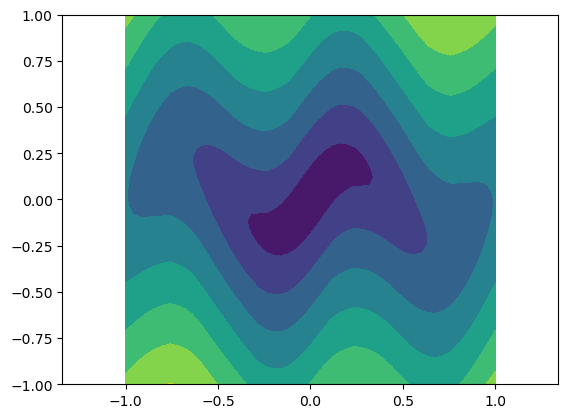

In [26]:
plt.axis('equal')
plt.contourf(X0,X1,solution_Global);

In [27]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution_Sweep,nupdate_Sweep = SweepIteration(Update,u0,(coefs,offsets,gridScale))

CPU times: user 306 ms, sys: 1.37 ms, total: 308 ms
Wall time: 307 ms


In [28]:
%%time
u0=np.where(np.isnan(bc),np.inf,bc)
solution_FM,nupdate_FM = FastMarching(Update,u0,(coefs,offsets,gridScale))

CPU times: user 888 ms, sys: 2.22 ms, total: 890 ms
Wall time: 890 ms


As before, the number of updates per point is largest for global iteration, and smallest for the fast marching method.

In [29]:
print("Number of updates per point.")
print("Global iteration :",nupdate_Global)
print("Fast sweeping :",nupdate_Sweep)
print("Fast marching :",nupdate_FM)

Number of updates per point.
Global iteration : 65
Fast sweeping : 48
Fast marching : 3.021914648212226


The residue of the fast marching method is zero, up to machine precision. In constrast, the residue of the fast sweeping method and of the global iteration method is expected to be of the order of the prescribed tolerance $\epsilon$, here we defaulted to $\epsilon = 1e-6$.

In [30]:
residue_Global,residue_Sweep,residue_FM = (norm_infinity(Scheme(solution,coefs,offsets,gridScale))
                                           for solution in (solution_Global,solution_Sweep,solution_FM))
print("Numerical scheme residue.")
print("Global iteration :",residue_Global)
print("Fast sweeping :",residue_Sweep)
print("Fast marching :",residue_FM)

Numerical scheme residue.
Global iteration : 2.930180381888192e-06
Fast sweeping : 1.261707627264741e-09
Fast marching : 1.887379141862766e-14


## 4. GPU acceleration

Eikonal equation solvers can take advantage of GPU acceleration. We illustrate here the basic architecture and concepts of such implementations. 

**AGD library eikonal solver.** Note that an eikonal solver with many more features (source factorization, arbitrary dimension, anisotropic metrics, etc) is included in the AGD library. The one presented here is only intended as an introduction and for teaching purposes.

In [31]:
try: import cupy as cp
except ModuleNotFoundError: raise ad.DeliberateNotebookError("Cupy needed for the rest of this notebook")

DeliberateNotebookError: Cupy needed for the rest of this notebook

GPU acceleration is mostly visible on large test cases, preferably in three dimensions. In this illustration, we content ourselves with a two dimensional map of centre Pompidou.

In [35]:
im = imread("Notebooks_FMM/TestImages/centre_pompidou_800x546.png")
im = im[68:515,65:770]
dom = np.logical_and(np.logical_and(im[:,:,0]==0,im[:,:,1]==0),im[:,:,2]==1).T
cost_map = np.where(dom,1,np.inf).T
cost_map = cp.asarray(cost_map,dtype=np.float32)

NameError: name 'cp' is not defined

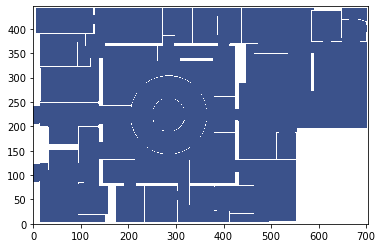

In [315]:
plt.contourf(cost_map.get());

### 4.1 Update operator

**Update of a point.**
For simplicity, we content ourselfves with the isotropic eikonal equation $\|\nabla u\| = c$ in two dimensions, in contrast with the Riemannian eikonal equation addressed above. We use the standard Rouy-Tourin discretization, reading
$$
    \max\{0,u(x)-u(x-h e_1), u(x)-u(x+h e_1)\}^2 + \max\{0,u(x)-u(x-h e_2), u(x)-u(x+h e_2)\}^2 = h^2 c(x)^2,
$$
where $(e_1,e_2)$ is the canonical basis of $R^2$.

The update operator is defined as the solution $u(x)$ of this equation, when the neighbor values $u(x\pm h e_1)$ and $u(x\pm h e_2)$ are fixed.
It can be computed as follows : 
* define $v_0 = \min\{u(x-h e_1), u(x+h e_1)\}$, $v_1 = \min\{u(x-h e_1), u(x+h e_1)\}$.
* define $w_0 = \min\{v_0,v_1\}$ and $w_1=\max\{v_0,v_1\}$.
* define $C = h c(x)$.

The equation to be solved, with unknown $\lambda = u(x)$, now reads:
$$
    (\lambda-w_0)_+^2 + (\lambda-w_0)_+^2 = C^2.
$$
The solution $\lambda$ is :
* $C+w_0$ if this value is smaller than $w_1$.
* the largest root of the quadratic equation  $(\lambda-w_0)^2 + (\lambda-w_0)^2 = C^2$ otherwise.


**Update of a block.**
We group points into blocks of shape $8\times 8$. Accordingly, a block of $64$ GPU threads loads the solution values at these points as well as their neighbors, into shared memory. Each GPU thread is responsible for one point in the block, and updates its value a in parallel. These updates are repeated a fixed number of times, so that the information can propagate through the block. Afterwards, the block data is written back from shared memory to main GPU memory.

**Opportunity for optimization.** Loading and writing the solution values accounts for a significant portion of computation time, and could be accelerated by reorganizing the memory layout in such way that the unknowns associated to the $64$ elements of an $8\times 8$ block are contiguous in memory.

### 4.2 Cuda kernel

**Main domain.**
The eikonal PDE is solved on a domain of size `xmax_ * ymax_`, whose point coordinates are denoted `x_` and `y_`, with `0 <= x_ < xmax_` and `0 <= y_ < ymax_`.

**Subdomains.**
A block of threads works on a subdomain of size `10 * 10`, whose point coordinates are denoted `x` and `y`, with `0 <= x <10` and `0 <= y < 10`. The subdomain is divided into two regions:
* the *interior*, where `1 <= x < 9` and `1 <= y < 9`, contains `8*8 = 64` points each handled by one thread within the block. (This means that `64` threads are used.) The values corresponding to these points are loaded, processed and updated.
* the *boundary* which is the complement of the interior. The values corresponding to these points are loaded, but not updated.

The position of a subdomain is characterized by two variables `X` and `Y`. The interiors of distinct subdomains are disjoints, but they boundaries overlap. The mapping from the subdomain to the domain is `x_ = 8*X + x - 1` and `y_ = 8*Y + y - 1`.

<!---
**Numerical scheme.**
We solve the isotropic eikonal equation, using the standard scheme of Rouy, which can be written:
$$
    (\lambda - v_0)_+^2 + (\lambda-v_1)_+^2 = c(x,y)^2,
$$
where $v_0 = \min\{u(x+1,y),u(x-1,y)\}$ and $v_1 = \min\{u(x,y+1),u(x,y-1)\}$. The unknown $u$ is extended by $+\infty$ outside of the domain.
--->

<!---ExoFR
Compléter le noyau cuda ci-dessous.
--->

<!---ExoCode
try: kernel=open("TestData/IsoEik_GPU_exo.h").read()
except FileNotFoundError: 
    import urllib.request; 
    kernel=urllib.request.urlopen("https://dl.dropbox.com/s/7w46ai2v62e2k7e/IsoEik_GPU_exo.h?dl=0").read().decode("utf-8")
--->

In [350]:
try: kernel=open("TestData/IsoEik_GPU.h").read()
except FileNotFoundError: import urllib.request; kernel=urllib.request.urlopen("https://dl.dropbox.com/s/rzprc0cxn97fss2/IsoEik_GPU.h?dl=0").read().decode("utf-8")

In [351]:
print(kernel)

const float tol = 1e-8; // Stopping criterion tolerance
const int niter = 8; // Iterations within a block

extern "C" { 
__global__ void eikonal_update(float * u_, float * cost_, 
int * update_list, char * update_next, int xmax_, int ymax_){

// Expecting threadDim.x=64, threadDim.y=threadDim.z=blockDim.y=blockDim.z=1
const int tid = threadIdx.x;
const int bid = blockIdx.x;


// Blocks are organized in a grid of size Xmax x Ymax
// The current block has position (X,Y) within this grid
const int Xmax = 1+(xmax_-1)/8, Ymax = 1+(ymax_-1)/8;
const float inf = 1./0.;

__shared__ int X,Y;
__shared__ bool updated; // Wether this block was significantly updated

if(tid==0){
	const long n = update_list[bid];
	X = n/Ymax; Y = n%Ymax;
	updated=false;
}
__syncthreads();

// Load the solution values at the points of the block and a layer of neighbors
__shared__ float u[10][10];

for(int r=0; r<2; ++r){
	const int m = tid + r*blockDim.x;
	if(m>=100) break;
	const int x = m/10, y=m%10;

	const int x_

In [318]:
eikonal_gpu_update = cp.RawKernel(kernel,'eikonal_update')

### 4.3 Global iteration

We update here all blocks in parallel, an approach also known as Jacobi iteration. As a result a many of the updates of a given block are actually useless : those before the front reaches the block, and those after the solution values have stabilized on the block. 

In [36]:
xseed,yseed = 102,15; cost = cost_map
#xseed,yseed = 3,3; cost = cp.ones((18,23),dtype=np.float32); cost[7,:10]=np.inf #Small instance for testing

In [320]:
u = np.full_like(cost,np.inf)
Shape = tuple(int(np.ceil(s/8)) for s in u.shape)
update_next = cp.full(Shape,0,dtype=np.uint8)

In [327]:
%%time
# Make sure the arrays are C-contiguous (silent bug otherwise)
u,cost,update_next = [cp.ascontiguousarray(e) for e in (u,cost,update_next)]

# Initialize data
u.fill(np.inf); u[xseed,yseed]=0
update_list = cp.arange(np.prod(Shape),dtype=np.int32)

# Global updates (Bounded number of iterations, just to be safe)
for it in range(2000): 
    update_next.fill(0)
    eikonal_gpu_update( (update_list.size,), (64,), (u,cost,update_list,update_next,*u.shape))
    if not np.any(update_next): break

Wall time: 165 ms


In [328]:
print(f"Number of iterations : {it}")
print(f"Mean number of block udpates per iteration : {update_list.size}")

Number updates : 209
Number of block udpates : 209


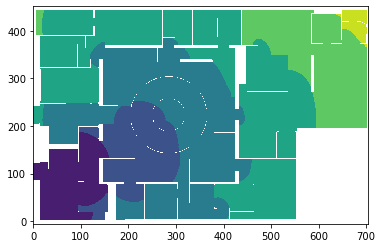

In [329]:
plt.axis('equal')
plt.contourf(u.get());

In [330]:
u_global = u.copy()

The solution has indeed stabilized: further updates have no effect.

In [331]:
eikonal_gpu_update( (update_list.size,), (64,), (u_global,cost,update_list,update_next,*u.shape))
assert np.nanmax(np.abs(u_global-u)) == 0.

### 4.4 Adaptive Gauss-Siedel iteration

We update a block when the value at one of its neighbors has changed, following a strategy often referred to as the AGSI. Many other strategies exist, going by the names of fast-sweeping, fast-iterative-method, etc

In [346]:
%%time
# Make sure the arrays are C-contiguous (silent bug otherwise)
u,update_next = [cp.ascontiguousarray(e) for e in (u,update_next)]

# Initialize data
u.fill(np.inf); u[xseed,yseed]=0
update_next.fill(0); update_next[xseed/8,yseed/8]=1
update_counter = np.zeros_like(update_next,dtype=np.int32)

# AGSI localized updates (Bounded number of iterations, just to be safe)
for it in range(1000): 
    update_counter+=update_next
    update_list = np.flatnonzero(update_next); update_list = cp.ascontiguousarray(update_list,dtype=np.int32)
    if update_list.size==0: break
    update_next.fill(0)
    eikonal_gpu_update( (update_list.size,), (64,), (u,cost,update_list,update_next,*u.shape))

Wall time: 111 ms


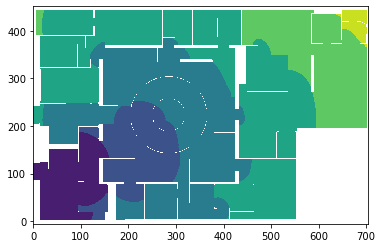

In [347]:
plt.axis('equal')
plt.contourf(u.get());

Computation time is not much faster in this instance, because it is small and therefore not enough parallelism can be exploited by the GPU. (More substantial differences are obtained with 3D problems.) Nevertheless on can check that the number of bloc updates is significantly reduced. A further computation time reduction could be obtained using the FIM or by adjusting parameters such as the number of iterations per block within the cuda kernel.

In [344]:
print(f"Number of iterations {it}")
print(f"Mean number of block updates",np.mean(update_counter))

Number of iterations 212
Mean number of block updates 43.401685393258425


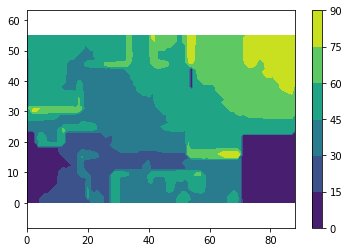

In [345]:
plt.contourf(update_counter.get()) 
plt.axis('equal'); plt.colorbar();

The solution of the AGSI and of the global update are identical up to small numerical errors.

In [343]:
assert np.nanmax(np.abs(u_global-u))<1e-3